In [1]:
# Funktion zum Visualisieren
import matplotlib.pyplot as plt

def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('trainingsschritt')
    plt.ylabel('max_error_für_epoche')
    plt.show()

In [2]:
# Import von Tensorflow, Keras-Layers, dem Model-Object und dem Gradient-Descent-Optimizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [3]:
# Funktion, die uns ein lineares Model mit einem Input- und einem Fully-Connected Output-Layer zurückgibt.
def build_model(n_inputs, n_outputs):
    # Input layer mit n_inputs Inputs
    input_layer = Input((n_inputs,), name='Inputs (x0, x1)')
    # Fully-Connected Layer (= Dense) mit n_outputs Neuronen, welches seinen Input vom Layer 'input_layer' erhält.
    # Den Output des Layers nennen wir 'x'. Wir benutzen vorerst keinen Bias. (Was es mit dem Bias auf sich hat lernen wir in der nächsten Lektion.)
    # Die Gewichte werden per default gemäß Glorot-Uniform initialisiert.
    x = Dense(n_outputs, use_bias=False, name='x')(input_layer)
    # Model erstellen.
    model = Model(input_layer, x)
    return model

In [14]:
"""
Bauen wir ein Model mit 2 Inputs und einem Output.
Mit .summary() können wir den Graphen des Models betrachten.

Zu bemerken ist: Der Output Shape jedes Layers hat ein 'None' in der ersten Dimension. In ein Tensorflow-Model können wir nicht einfach
die Inputs für ein einzelnes Trainingsbeispiel wie bspw. die Liste [0, 1] hineingeben, sondern immer nur eine Liste von Trainingsbeispielen.
Also [[0,1],] würde funktionieren. Das hat den Grund, dass wir so einen Trainingsschritt für mehrere Trainingsbeispiele gleichzeitig vollziehen können.
Möchten wir bspw. einen Trainingsschritt auf unserem ganzen Datenset vollziehen, können wir die Liste unserer Input-Paare [[0, 0], [0, 1], [1, 1], [1, 0]]
in das Model geben. Die Anzahl von Trainingsbeispielen pro Trainingsschritt nennt man 'batch size'. So können wir uns bei unserem Datenset zwischen einer 
batch size zwischen einschließend 1 und 4 entscheiden. 'None' ist lediglich ein Platzhalter für die batch size des Models und zeigt an, dass diese variabel ist.
Was für einen Einluss hat die batch size? Je höher, desto schneller kann das Training prinzipiell ausgeführt werden. Jedoch ist die batch size durch unseren RAM
bzw. VRAM limitiert.
"""
model = build_model(n_inputs=2, n_outputs=1)
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (x0, x1) (InputLayer  [(None, 2)]              0         
 )                                                               
                                                                 
 x (Dense)                   (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Datenset
# [[x0, x1], y/label]
Dataset = [
    [[0,0], 0],
    [[0,1], 1],
    [[1,1], 1],
    [[1,0], 0]
]

# Tensorflow benötigt unsere Trainingsdaten für den Graphen, den wir in train_step definiert haben, als tf.tensor.
# inputs in neue Liste schreiben
inputs = [example[0] for example in Dataset]
print(inputs)
# labels in neue Liste schreiben
labels = [example[1] for example in Dataset]
print(labels)

# Legen wir uns also auf eine batch size von 4 fest. Dann konvertieren wir die inputs und labels gemeinsam in jeweils einen Tensor.
# Wählten wir eine batch size von 1, so müssten wir jedes Element von inputs in einen Tensor umwandeln und diese in einer
# Liste speichern. Analog für labels.
inputs = tf.convert_to_tensor(inputs)
labels = tf.convert_to_tensor(labels)
print(inputs.shape)
print(labels.shape)

# inputs hat nun den .shape (4,2) = (batch_size, n_inputs).
# labels hat den .shape (4,) = (batch_size, ). Das Model akzeptiert, wie wir der Summary entnehmen können als Label aber nur einen Tensor vom
# shape (None, 1). Es braucht also eine Liste von Listen mit jeweils einem Element. Wir können mittels tf.expand_dims eine Dimension entlang der axis hinzufügen.

labels = tf.expand_dims(labels, axis=1)
print('korrigierter shape: ', labels.shape)
print(inputs)
print(labels)

# Letztlich liegen die tensoren im int32 Format vor, weil wir das ursprüngliche Datenset nur aus Integern bestanden hat. Tensorflow-Models arbeiten mit float32,
# also müssen wir noch den Datentyp der Tensoren ändern.
inputs = tf.cast(inputs, dtype=tf.float32)
labels = tf.cast(labels, dtype=tf.float32)
print('korrigierter dtype: ')
print(inputs)
print(labels)

[[0, 0], [0, 1], [1, 1], [1, 0]]
[0, 1, 1, 0]
(4, 2)
(4,)
korrigierter shape:  (4, 1)
tf.Tensor(
[[0 0]
 [0 1]
 [1 1]
 [1 0]], shape=(4, 2), dtype=int32)
tf.Tensor(
[[0]
 [1]
 [1]
 [0]], shape=(4, 1), dtype=int32)
korrigierter dtype: 
tf.Tensor(
[[0. 0.]
 [0. 1.]
 [1. 1.]
 [1. 0.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[0.]
 [1.]
 [1.]
 [0.]], shape=(4, 1), dtype=float32)


In [15]:
# Definieren der Lossfunction L(x-y)=(x-y)^2 mit Tensorflow/Keras-Funktionen.
# Bemerke: Wir erhalten, wenn wir mit einer batch size von 4 rechnen, einen tensor mit shape (4,1) aus dem Model.
# Der Loss wird dann für jeden dieser 4 Outputs jeweils zusammen mit dem entsprechenden Label berechnet, wir erhalten also 4 Losses.
# Wir berechnen davon einfach die Summe, sodass wir am Ende nur einen Loss haben.
def lossfunction(x, y):
    loss = tf.square(tf.subtract(x,y))
    loss = tf.reduce_mean(loss)
    return loss

# Gradient Descent-Optimizer anlegen
optimizer = SGD(learning_rate=0.5)

# Definieren des Trainingsschritts als tensorflow-Funktion.
@tf.function
def train_step(inputs, y, Model):
    # Ein GradientTape notiert alle Rechenschritte des eingerückten Graphen für ein Trainingsbeispiel.
    # In unserem Fall notiert es für ein Trainingsbeispiel alle Rechenschritte, die das Model und die Lossfunction vollziehen.
    # Voraussetzung ist, dass diese mittels Tensorflow oder Keras-Funktionen ausgedrückt wurden, was wir getan haben.
    with tf.GradientTape() as tape:
        x = Model(inputs)
        loss = lossfunction(x, y)
    # Die Methode .gradient, die wir auf dem GradientTape ausführen, gibt eine Liste zurück, die für jeden trainierbaren Parameter des Models die 
    # Ableitung des losses in Abhängigkeit des jeweiligen trainierbaren Parameters zurückggibt. Wir müssen also keine Ableitungen mehr selbstständig ausrechnen.
    gradients = tape.gradient(target=loss, sources=Model.trainable_weights)
    # Mit der Methode .apply_gradients des Optimizers können wir jetzt mittels der gradients-liste jeden trainierbaren Parameter des Models optimieren.
    # Dafür müssen wir ein iterierbares Objekt erstellen, dessen Elemente jeweils ein Paar aus einem Model-Parameter und dem zugehörigen Gradient ist.
    # Die Python-Funktion zip erstellt für 2 gleich-lange Listen ein solches Objekt.
    optimizer.apply_gradients(zip(gradients, Model.trainable_weights))
    return loss

1.2689388
0.6622134
0.36927223
0.20751423
0.116714165
0.065650925
0.036928598
0.020772334
0.011684436
0.006572497
0.003697031
0.0020795804
0.001169764
0.0006579925
0.0003701206
Nach Training    : w0 = [0.02040553], w1 = [0.97959447]


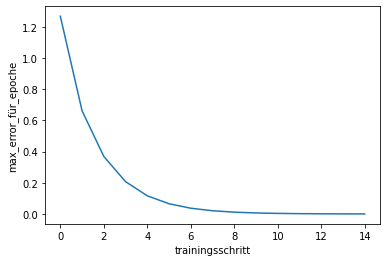

In [16]:
# Trainingsloop
num_epochs = 15

fehlerhistorie = []
for epoch in range(num_epochs):
    loss = train_step(inputs, labels, model)
    loss = loss.numpy()
    print(loss)
    fehlerhistorie.append(loss)

#print('Fehlerhistorie   :', fehlerhistorie)
weights = model.layers[1].get_weights()[0]
print('Nach Training    : w0 = '+str(weights[0])+', w1 = '+str(weights[1]))
plot_losses(fehlerhistorie)